# Using Feat's archive

Feat optimizes a population of models. 
At the end of the run, it can be useful to explore this population to find a trade-off between objectives, 
such as performance and complexity. 

In this example, we apply Feat to a regression problem and visualize the archive of representations. 

Note: this code uses the Penn ML Benchmark Suite (https://github.com/EpistasisLab/penn-ml-benchmarks/) to fetch data. You can install it using `pip install pmlb`.


First, we import the data and create a train-test split.

In [1]:
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np
# fix the random state
random_state=42
dataset='690_visualizing_galaxy'
X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=random_state)

Then we set up a Feat instance and train the model, storing the final archive.

In [2]:
from feat import FeatRegressor


est = FeatRegressor(
    pop_size=100, # population size
    gens=100, # maximum generations                            
    max_time=60, # max time in seconds 
    max_depth=2, # constrain features depth                                                      
    max_dim=5, # constrain representation dimensionality                                                      
    random_state=random_state,                                                            
    hillclimb=True, # use stochastic hillclimbing to optimize weights                                                   
    iters=10, # iterations of hillclimbing
    n_jobs=4, # restricts to single thread                                                      
) 


print('FEAT version:', est.__version__)
est

FEAT version: 0.5.2.post75


FeatRegressor(backprop=False, batch_size=0, classification=False,
              corr_delete_mutate=False, cross_rate=0.5, erc=False, fb=0.5,
              feature_names='',
              functions=['+', '-', '*', '/', '^2', '^3', 'sqrt', 'sin', 'cos',
                         'exp', 'log', '^', 'logit', 'tanh', 'gauss', 'relu',
                         'split', 'split_c', 'b2f', 'c2f', 'and', 'or', 'not',
                         'xor', '=', '<', '<=', '>', '>=', 'if', ...],
              gens=100, hillclimb=True, iters=10, logfile='', lr=0.1,
              max_depth=2, max_dim=5, max_stall=0, max_time=60,
              ml='LinearRidgeRegression', n_jobs=4, normalize=True,
              objectives=['fitness', 'complexity'], otype='a', pop_size=100,
              protected_groups='', random_state=42, residual_xo=False,
              root_xo_rate=0.5, save_pop=0, scorer='', ...)

In [3]:
# train the model
est.fit(X_t,y_t)


FeatRegressor(backprop=False, batch_size=0, classification=False,
              corr_delete_mutate=False, cross_rate=0.5, erc=False, fb=0.5,
              feature_names='',
              functions=['+', '-', '*', '/', '^2', '^3', 'sqrt', 'sin', 'cos',
                         'exp', 'log', '^', 'logit', 'tanh', 'gauss', 'relu',
                         'split', 'split_c', 'b2f', 'c2f', 'and', 'or', 'not',
                         'xor', '=', '<', '<=', '>', '>=', 'if', ...],
              gens=100, hillclimb=True, iters=10, logfile='', lr=0.1,
              max_depth=2, max_dim=5, max_stall=0, max_time=60,
              ml='LinearRidgeRegression', n_jobs=4, normalize=True,
              objectives=['fitness', 'complexity'], otype='a', pop_size=100,
              protected_groups='', random_state=42, residual_xo=False,
              root_xo_rate=0.5, save_pop=0, scorer='', ...)

In [4]:
# get the test score
test_score = {}
test_score['feat'] = mse(y_v,est.predict(X_v))

# store the archive
archive = est.cfeat_.get_archive(True)

# print the archive
print('complexity','fitness','validation fitness',
     'eqn')
order = np.argsort([a['complexity'] for a in archive])
complexity = []
fit_train = []
fit_test = []
eqn = []

for o in order:
    model = archive[o]
    if model['rank'] == 1:
        print(model['complexity'],
              model['fitness'],
              model['fitness_v'],
              model['eqn'],
             )

        complexity.append(model['complexity'])
        fit_train.append(model['fitness'])
        fit_test.append(model['fitness_v'])
        eqn.append(model['eqn'])

complexity fitness validation fitness eqn
1 1834.9365234375 1672.86279296875 [x_1]
2 978.2460327148438 810.285400390625 [x_1][x_3]
3 948.1231689453125 814.2865600585938 [x_3][x_0][x_1]
4 915.998291015625 787.1356811523438 [x_3][x_2][x_0][x_1]
6 915.9979858398438 787.1354370117188 [x_1][(0.5418*x_1-0.5815*x_0)][x_2][x_3]
7 542.2037963867188 533.512939453125 [x_3][tanh(0.8951*x_1)]
8 465.80938720703125 503.4342041015625 [x_1][tanh(0.8951*x_1)][x_3]
9 428.57049560546875 431.0047912597656 [x_2][tanh(0.8951*x_1)][x_1][x_3]
10 394.3541564941406 405.9887390136719 [x_3][tanh(0.8951*x_1)][x_2][x_0][x_1]
12 394.3539733886719 405.9885559082031 [x_2][tanh(0.8951*x_1)][x_3][(0.5418*x_1-0.5815*x_0)][x_0]
13 380.3902893066406 468.53033447265625 [x_2][tanh(0.8951*x_1)][relu(0.7307*x_3)][x_1][x_0]
14 379.486328125 368.8024597167969 [x_1][tanh(0.8951*x_1)][x_2][sin(0.9585*x_3)]
15 354.5791320800781 383.6985168457031 [x_3][tanh(0.8951*x_1)][x_2][sin(0.9398*x_0)][x_1]
17 344.9056701660156 373.072967529296

For comparison, we can fit an Elastic Net and Random Forest regression model to the same data.


In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_state)

rf.fit(X_t,y_t)

test_score['rf'] = mse(y_v,rf.predict(X_v))


In [6]:
from sklearn.linear_model import ElasticNet

linest = ElasticNet()

linest.fit(X_t,y_t)

test_score['elasticnet'] = mse(y_v,linest.predict(X_v))


Let's look at the test set mean squared errors by method.

In [7]:
test_score

{'feat': 381.70598775221976,
 'rf': 347.15749506172847,
 'elasticnet': 919.3515337699572}

## Visualizing the Archive

Let's visualize this archive with the test scores. This gives us a sense of how increasing the representation
complexity affects the quality of the model and its generalization.


best: 55
middle: 14
small: 3
complexity [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 22, 24, 29, 34, 37, 49, 54, 55, 59, 114, 153, 244]


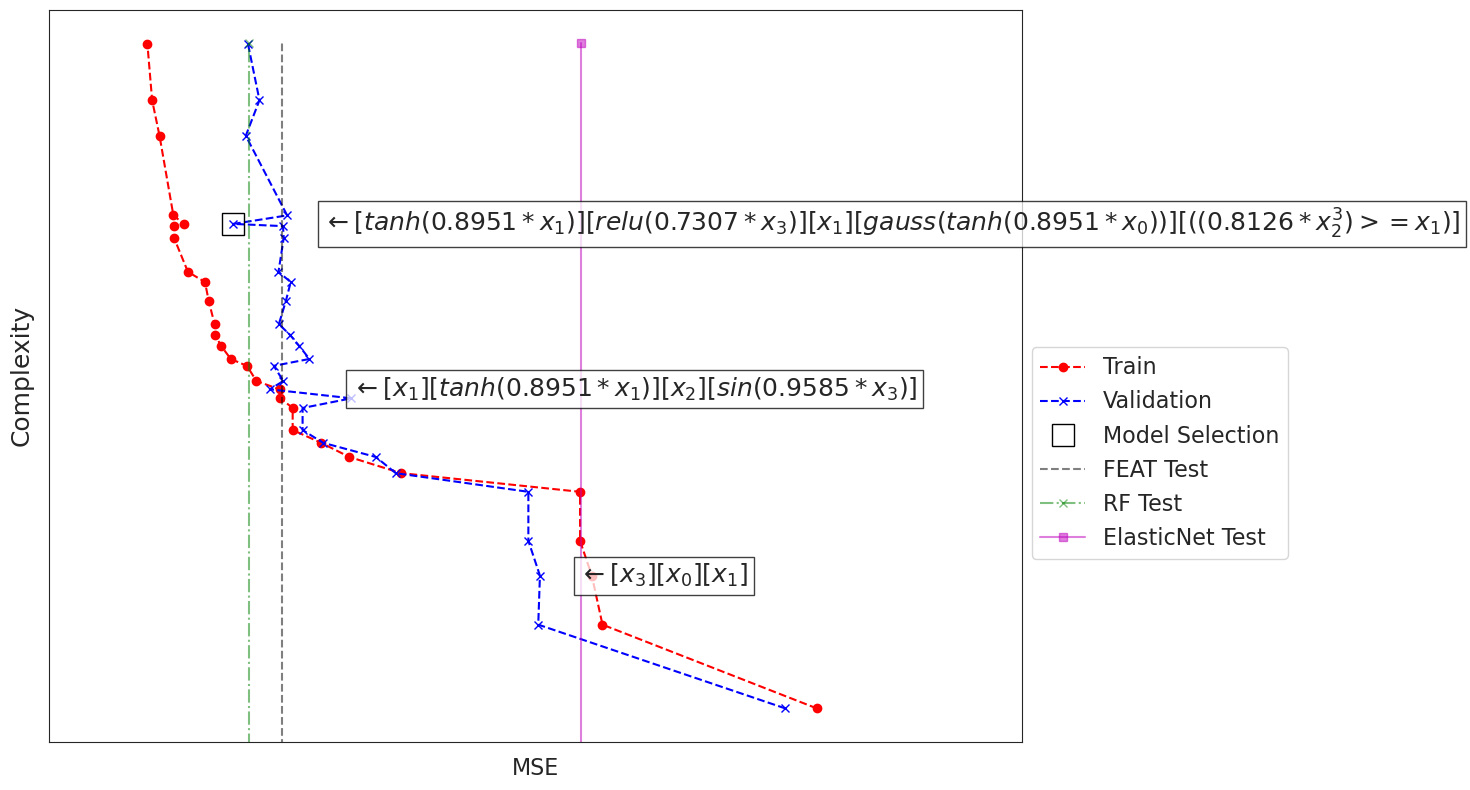

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

matplotlib.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline 
sns.set_style('white')
h = plt.figure(figsize=(14,8))

# plot archive points 
plt.plot(fit_train,complexity,'--ro',label='Train',markersize=6)
plt.plot(fit_test,complexity,'--bx',label='Validation')
# some models to point out
best = np.argmin(np.array(fit_test))
middle = np.argmin(np.abs(np.array(fit_test[:best])-test_score['rf']))
small = np.argmin(np.abs(np.array(fit_test[:middle])-test_score['elasticnet']))

print('best:',complexity[best])
print('middle:',complexity[middle])
print('small:',complexity[small])
plt.plot(fit_test[best],complexity[best],'sk',markersize=16,markerfacecolor='none',label='Model Selection')

# test score lines
y1 = -1
y2 = np.max(complexity)+1
plt.plot((test_score['feat'],test_score['feat']),(y1,y2),'--k',label='FEAT Test',alpha=0.5)
plt.plot((test_score['rf'],test_score['rf']),(y1,y2),'-.xg',label='RF Test',alpha=0.5)
plt.plot((test_score['elasticnet'],test_score['elasticnet']),(y1,y2),'-sm',label='ElasticNet Test',alpha=0.5)

print('complexity',complexity)
xoff = 100
for e,t,c in zip(eqn,fit_test,complexity):
    if c in [complexity[best],complexity[middle],complexity[small]]:
        t = t+xoff
        tax = plt.text(t,c,'$\leftarrow'+e+'$',size=18,horizontalalignment='left',
                      verticalalignment='center')
        tax.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='k'))

l = plt.legend(prop={'size': 16},loc=[1.01,0.25])
plt.xlabel('MSE',size=16)
plt.xlim(np.min(fit_train)*.75,np.max(fit_test)*2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.gca().set_yticklabels('')
plt.gca().set_xticklabels('')

plt.ylabel('Complexity',size=18)
h.tight_layout()

plt.show()

Note that ElasticNet produces a similar test score to the linear representation
in Feat's archive, and that Random Forest's test score is near the representation shown in the middle.

The best model, marked with a square, is selected from the validation curve (blue line).
The validation curve shows how models begin to overfit as complexity grows.
By visualizing the archive, we can see that some lower complexity models achieve nearly as good of a validation score.
In this case it may be preferable to choose that representation instead.

By default, FEAT will choose the model with the lowest validation error, marked with a square above. 
Let's look at that model.

the function `get_model()` will print a table of the learned features, optionally ordered by the magnitude of their weights.

In [9]:
print(est.get_model(False))

Weight	Feature
1547.33	offset
-182.50	tanh(0.8951*x_1)
37.58	relu(0.7307*x_3)
40.92	x_1
69.79	gauss(tanh(0.8951*x_0))
-17.11	((0.8126*x_2^3)>=x_1)

